This notebook loads the data sent by Luca on 19-feb-2018 (generated circa 2 weeks before that).

Tumor purity is  50%.

There are 6 categories: start of deletions, end of deletions and start of insertions - each for both germline and somatic. 

The windows are centered in any PBJ.

There are 8 channels per window: 4 from the normal cells and 4 from the tumor cells. 

The 4 channels are: exact matches coverage, regural coverage, number of left clips, number of right clips.

Total number of windows: 2 x 25723. 

Test accuracy after (non-optimized) training: 94%

Should be improved not only with baby-sitting the training but also with reducing windows size (some windows contain 2 different breakpoints) and with adding more charasteristic channels (the distances between paired reads and the split reads). And more data, of course.



## Load dependences and setting output configuration

In [94]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Check the content of some files

In [95]:
datapath = '/home/sonja/ChannelMaker_060218/'
a = np.load(datapath + 'BPJ_flag.npy')
a.shape

(25723,)

In [96]:
b = np.load(datapath + 'somatic_label_array_file.npy')
b.shape
b[0]

b'somatic_del_start'

## Load data from npy files

In [97]:
datapath = '/home/sonja/ChannelMaker_060218/'
germline_cube = np.load(datapath + 'germline_cube_data_file.npy')
somatic_cube = np.load(datapath + 'somatic_cube_data_file.npy')
germline_labels = np.load(datapath + 'germline_label_array_file.npy')
somatic_labels = np.load(datapath + 'somatic_label_array_file.npy')

### Check how categories are distributed in the input arrays

In [98]:
print(germline_labels[6625:6630])

[b'germline_del_start' b'germline_del_start' b'germline_del_start'
 b'germline_del_end' b'germline_del_end']


### Find  the indexes that split the categories

In [118]:
for i in range (0, germline_labels.shape[0] - 1):
    if (germline_labels[i] != germline_labels[i+1]):
        print(i , ': ', germline_labels[i] , germline_labels[i+1] )        

6627 :  b'germline_del_start' b'germline_del_end'
13351 :  b'germline_del_end' b'germline_ins_start'


### Set manually the variables denoting the splitting indexes (more categories for every new dataset)

In [99]:
last_del_start = 6627
last_del_end = 13351

### Check if the same splitters hold for somatic

In [100]:
for i in range (0, somatic_labels.shape[0] - 1):
    if (somatic_labels[i] != somatic_labels[i+1]):
        print(i , ': ', somatic_labels[i] , somatic_labels[i+1] )

6627 :  b'somatic_del_start' b'somatic_del_end'
13351 :  b'somatic_del_end' b'somatic_ins_start'


### Check sizes of arrays

In [101]:
qube_size = germline_cube.shape[0]
                            
germline_cube.shape

(25723, 9, 200)

In [102]:
somatic_cube.shape

(25723, 9, 200)

In [103]:
germline_labels.shape

(25723,)

In [104]:
somatic_labels.shape

(25723,)

### Eliminate GC content channel, at the moment it is just noise: 

In [ ]:
germline_cube_8channels = germline_cube[:,0:8,:] 
germline_cube_8channels.shape
somatic_cube_8channels = somatic_cube[:,0:8,:]
germline_cube_8channels.shape

## Split into training, validation and test datasets

From the germline set 

-- there will be 4000 training, 1000 validation and 1628 test windows for ´start of deletions´.

-- there will be 4000 training, 1000 validation and 1722 test windows for ´end of deletions´. 

For insertions the numbers are 8000, 2000, 2371. 
 



I decided to hardcode the following values because this way they are easier to read. 

In [105]:
X_train_germline = np.concatenate((germline_cube_8channels[0:4000], germline_cube_8channels[6628:10628],  germline_cube_8channels[13352:21352]),axis=0)
y_train_germline = np.concatenate((germline_labels[0:4000], germline_labels[6628:10628],  germline_labels[13352:21352]),axis=0)
X_val_germline = np.concatenate((germline_cube_8channels[4000:5000], germline_cube_8channels[10628:11628],  germline_cube_8channels[21352:23352]),axis=0)
y_val_germline = np.concatenate((germline_labels[4000:5000], germline_labels[10628:11628],  germline_labels[21352:23352]),axis=0)
X_test_germline = np.concatenate((germline_cube_8channels[5000:6628], germline_cube_8channels[11628:13350],  germline_cube_8channels[23352:]),axis=0)
y_test_germline = np.concatenate((germline_labels[5000:6628], germline_labels[11628:13350],  germline_labels[23352:]),axis=0)

Repeat the same for the somatic

In [106]:
X_train_somatic = np.concatenate((somatic_cube_8channels[0:4000], somatic_cube_8channels[6628:10628],  somatic_cube_8channels[13352:21352]),axis=0)
y_train_somatic = np.concatenate((somatic_labels[0:4000], somatic_labels[6628:10628],  somatic_labels[13352:21352]),axis=0)
X_val_somatic = np.concatenate((somatic_cube_8channels[4000:5000], somatic_cube_8channels[10628:11628],  somatic_cube_8channels[21352:23352]),axis=0)
y_val_somatic = np.concatenate((somatic_labels[4000:5000], somatic_labels[10628:11628],  somatic_labels[21352:23352]),axis=0)
X_test_somatic = np.concatenate((somatic_cube_8channels[5000:6628], somatic_cube_8channels[11628:13350],  somatic_cube_8channels[23352:]),axis=0)
y_test_somatic = np.concatenate((somatic_labels[5000:6628], somatic_labels[11628:13350],  somatic_labels[23352:]),axis=0)

Concatenate the previous germline and somatic datasets.

In [107]:
X_train = np.concatenate((X_train_germline, X_train_somatic), axis =0)
X_val = np.concatenate((X_val_germline, X_val_somatic), axis =0)
X_test = np.concatenate((X_test_germline, X_test_somatic), axis =0)
y_train = np.concatenate((y_train_germline, y_train_somatic), axis =0)
y_val = np.concatenate((y_val_germline, y_val_somatic), axis =0)
y_test = np.concatenate((y_test_germline, y_test_somatic), axis =0)

### Number of training, validation and test windows

In [108]:
X_train.shape

(32000, 8, 200)

In [109]:
X_val.shape

(8000, 8, 200)

In [110]:
X_test.shape

(11442, 8, 200)

In [111]:
number_channels = X_train.shape[1]
number_channels

8

## Plots several  windows from the germline SV category

In [112]:
n_windows = 30

In [113]:
from numpy import *
import math
import matplotlib.pyplot as plt


def plot_channels(start_window, n_windows):
    for i in range (start_window, start_window + n_windows):
        print(y_train[i], 'id:', i)
        for j in range (0, number_channels):
            shift = 0
            start = 0
            if j in [0,1,4,5]:
                shift = -60
            if j in [4,5,6,7]:
                start = 70
            Z = [start + shift + x + 5*j*4 for x in X_train[i][j]] 
            plt.ylim([-65,250])
            plt.plot(Z)
        plt.show()

b'germline_del_start' id: 3990


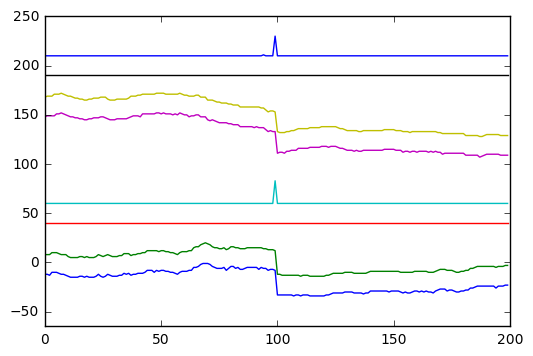

b'germline_del_start' id: 3991


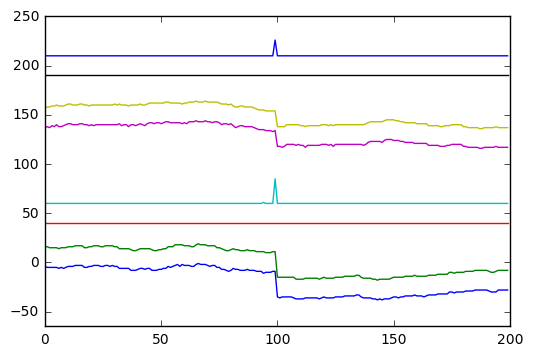

b'germline_del_start' id: 3992


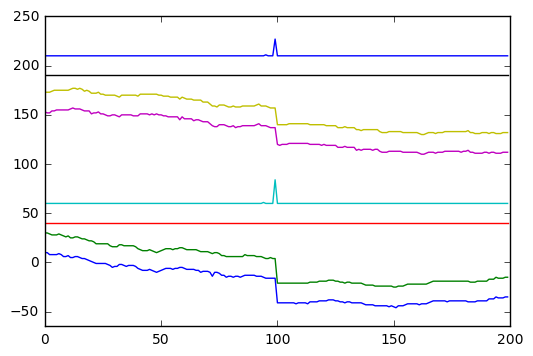

b'germline_del_start' id: 3993


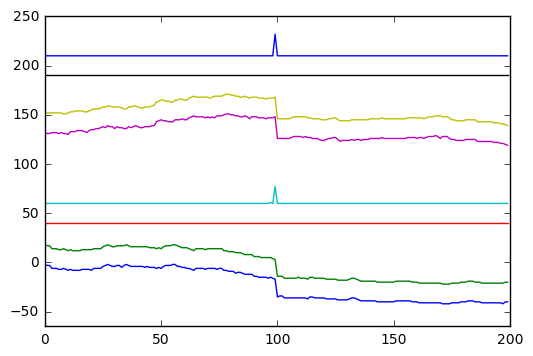

b'germline_del_start' id: 3994


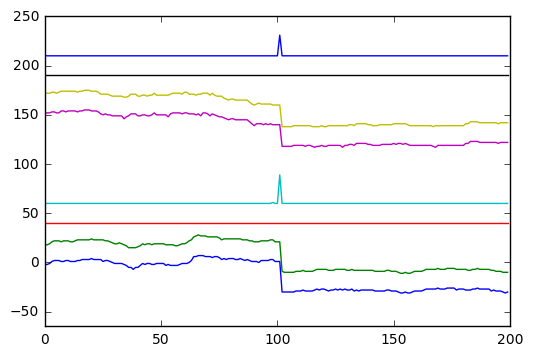

b'germline_del_start' id: 3995


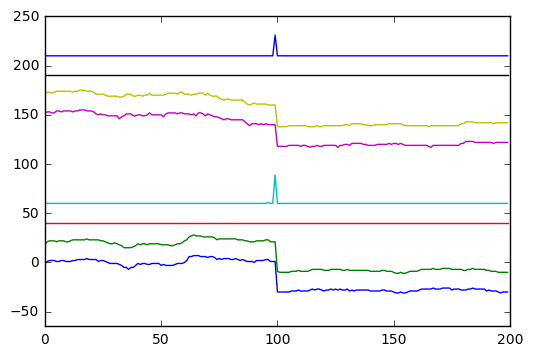

b'germline_del_start' id: 3996


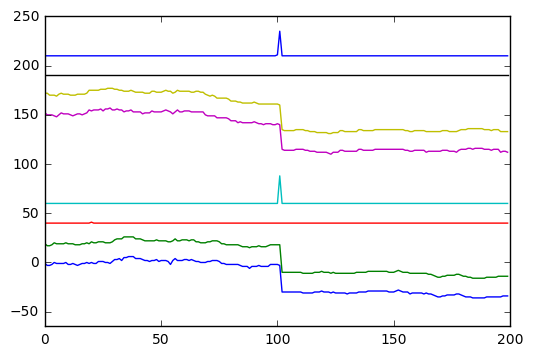

b'germline_del_start' id: 3997


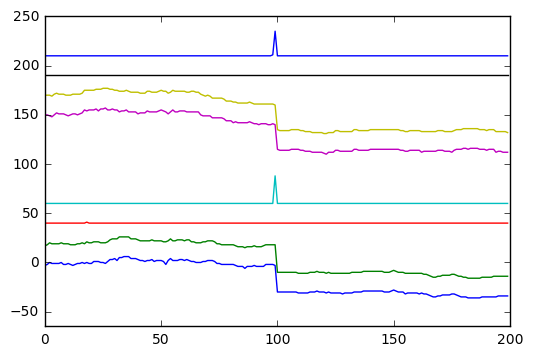

b'germline_del_start' id: 3998


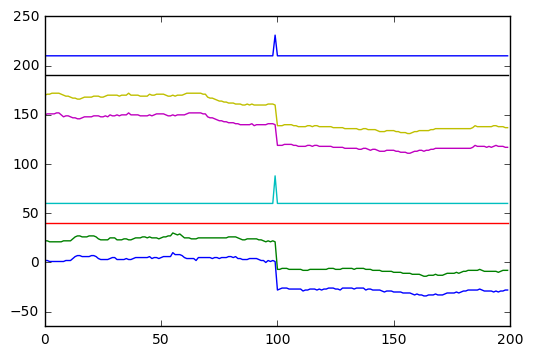

b'germline_del_start' id: 3999


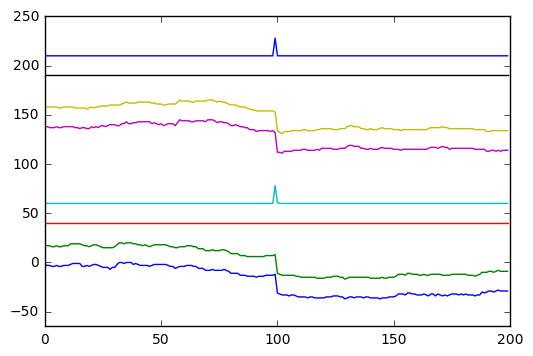

b'germline_del_end' id: 4000


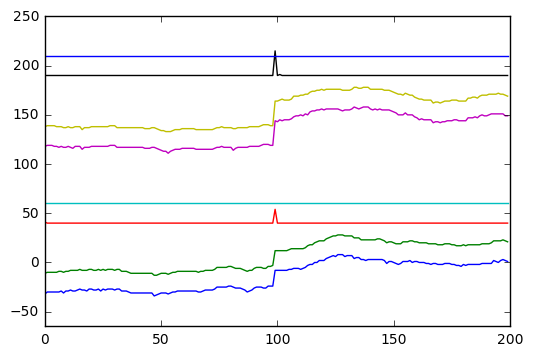

b'germline_del_end' id: 4001


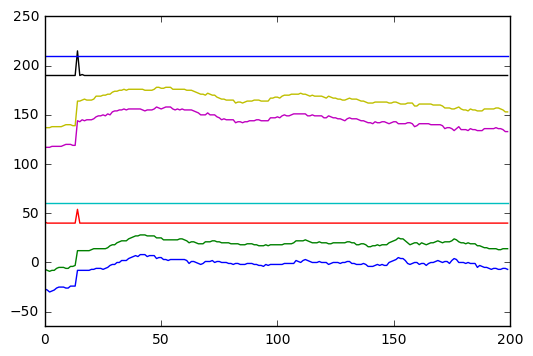

b'germline_del_end' id: 4002


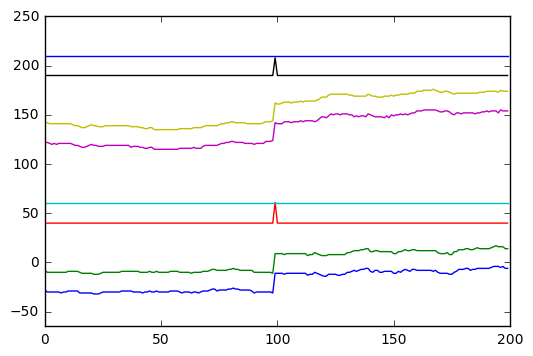

b'germline_del_end' id: 4003


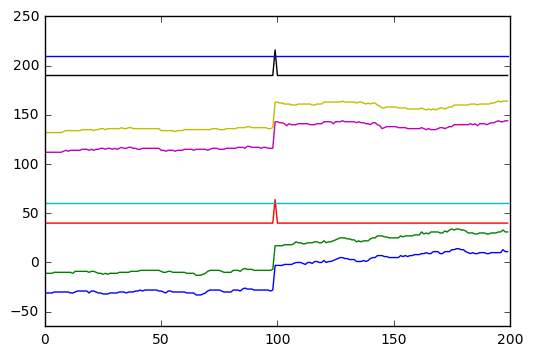

b'germline_del_end' id: 4004


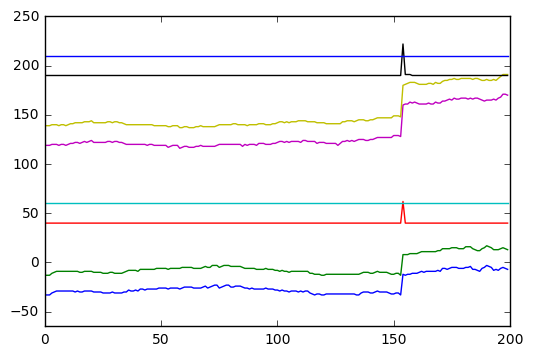

b'germline_del_end' id: 4005


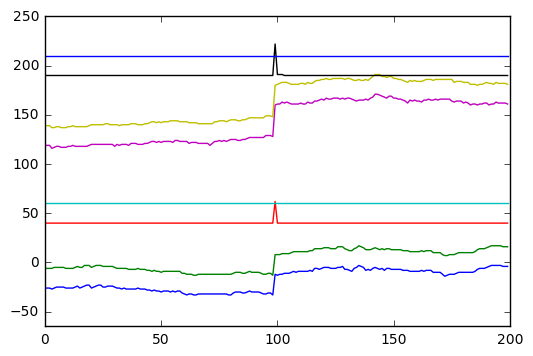

b'germline_del_end' id: 4006


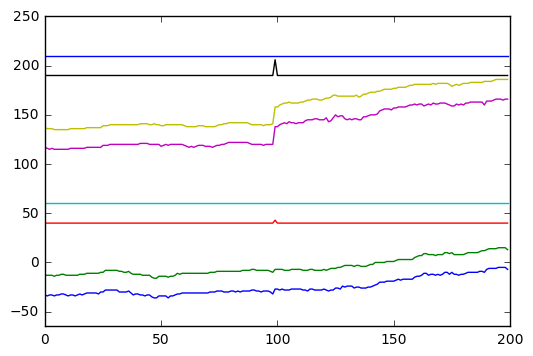

b'germline_del_end' id: 4007


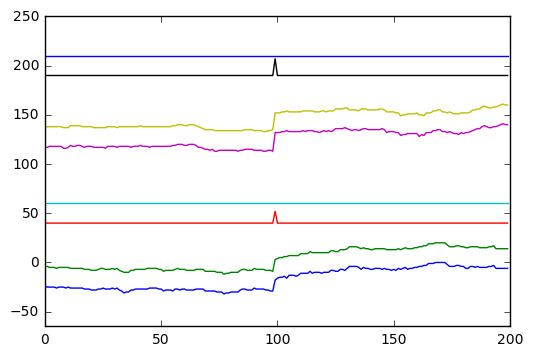

b'germline_del_end' id: 4008


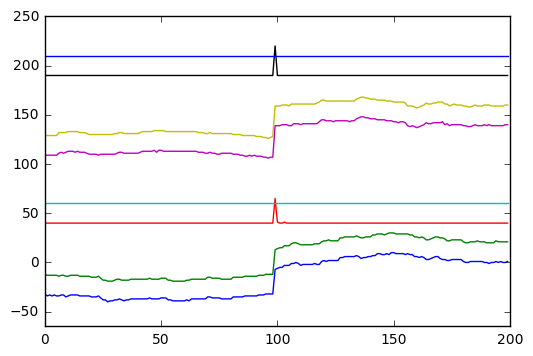

b'germline_del_end' id: 4009


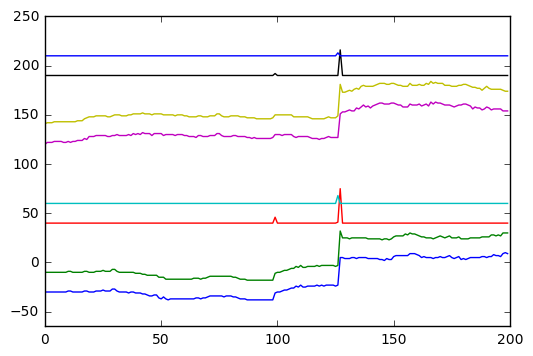

b'germline_del_end' id: 4010


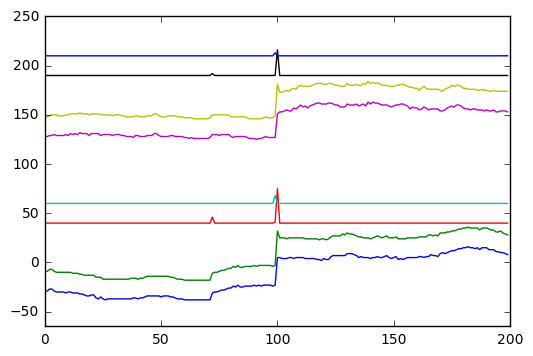

b'germline_del_end' id: 4011


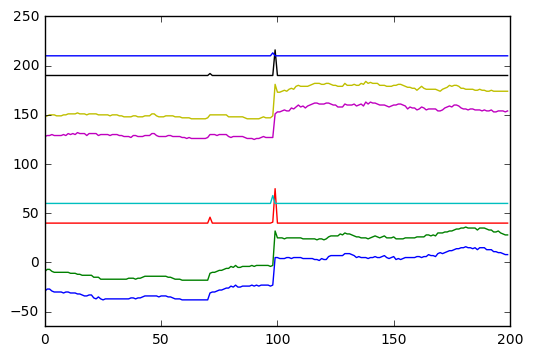

b'germline_del_end' id: 4012


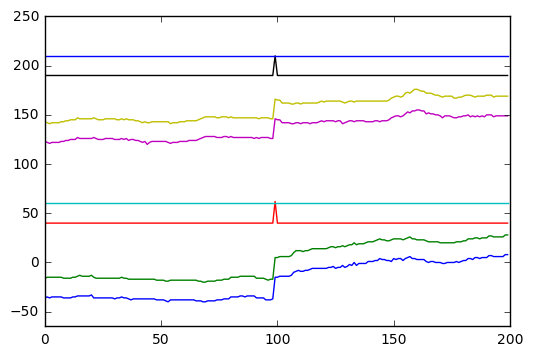

b'germline_del_end' id: 4013


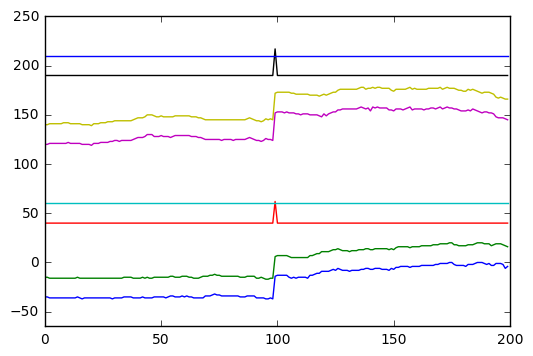

b'germline_del_end' id: 4014


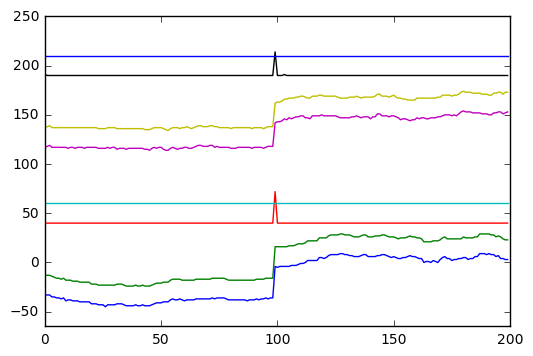

b'germline_del_end' id: 4015


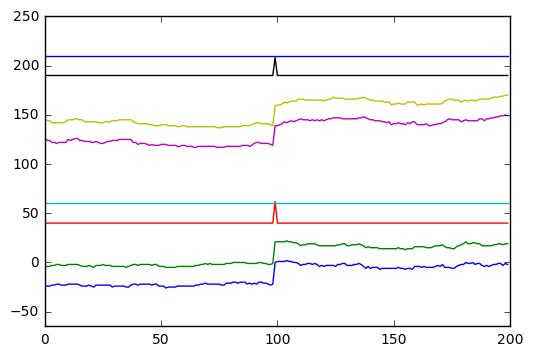

b'germline_del_end' id: 4016


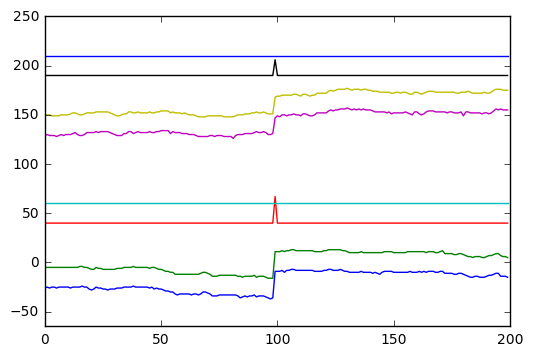

b'germline_del_end' id: 4017


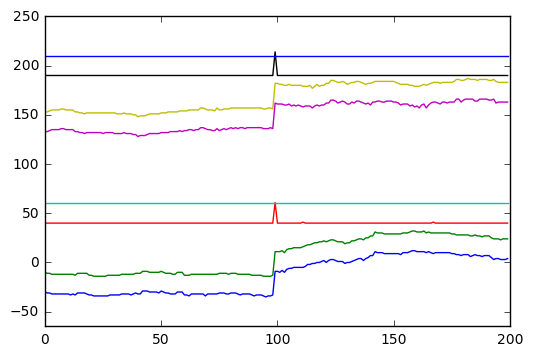

b'germline_del_end' id: 4018


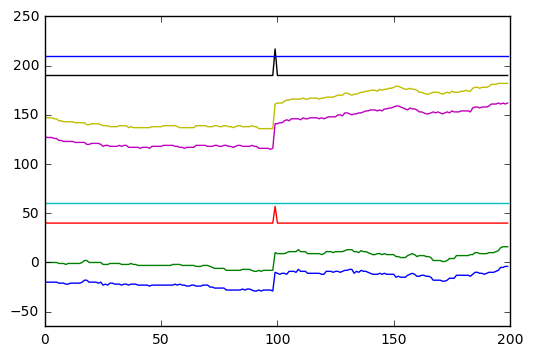

b'germline_del_end' id: 4019


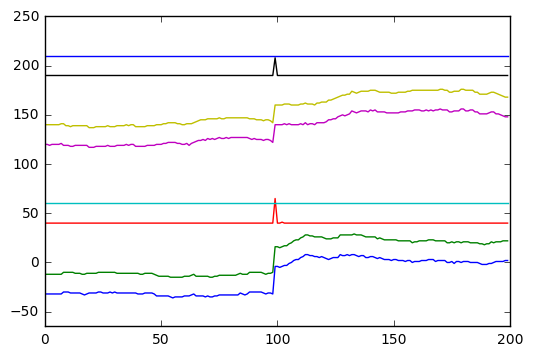

In [119]:
start_window = 3990
plot_channels(start_window, n_windows)

b'germline_del_end' id: 7985


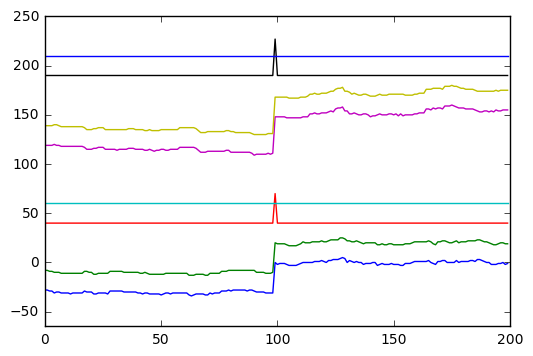

b'germline_del_end' id: 7986


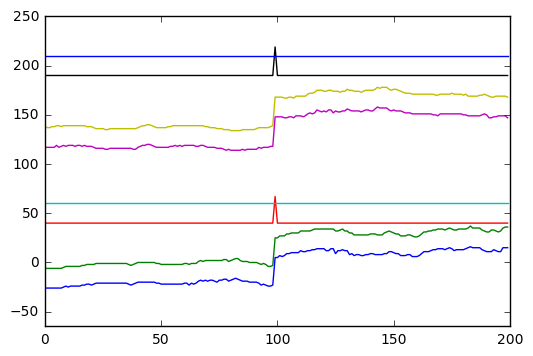

b'germline_del_end' id: 7987


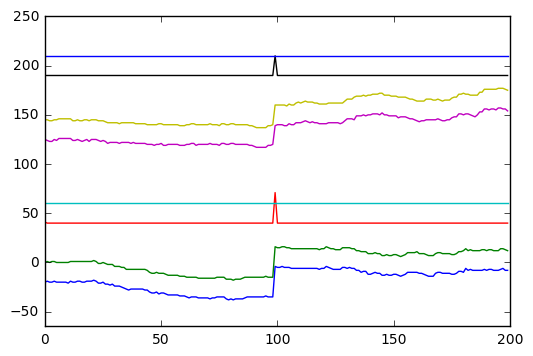

b'germline_del_end' id: 7988


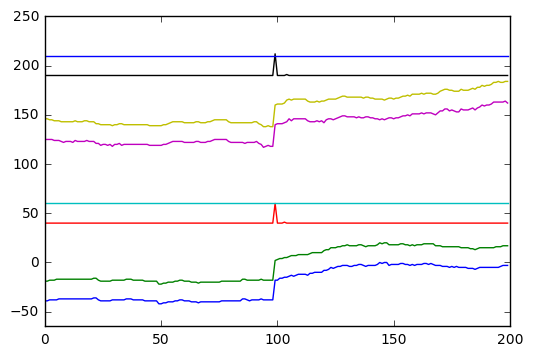

b'germline_del_end' id: 7989


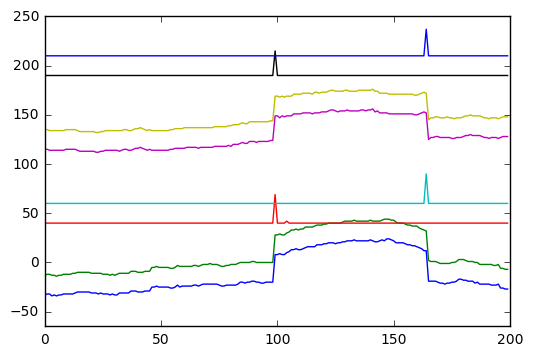

b'germline_del_end' id: 7990


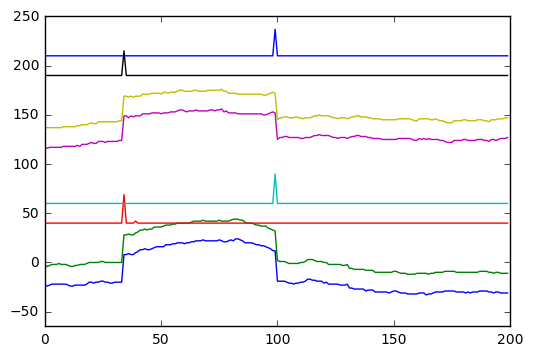

b'germline_del_end' id: 7991


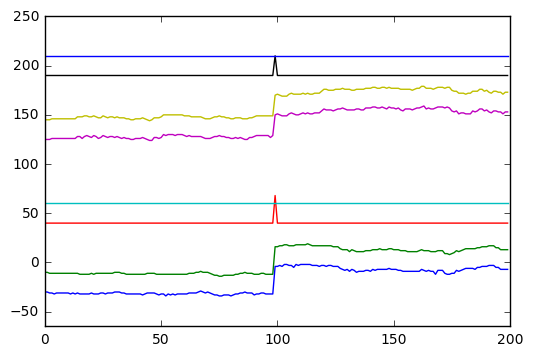

b'germline_del_end' id: 7992


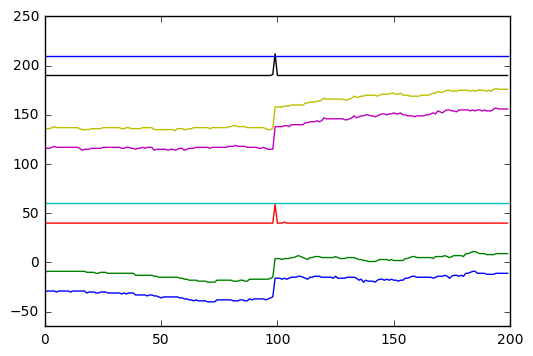

b'germline_del_end' id: 7993


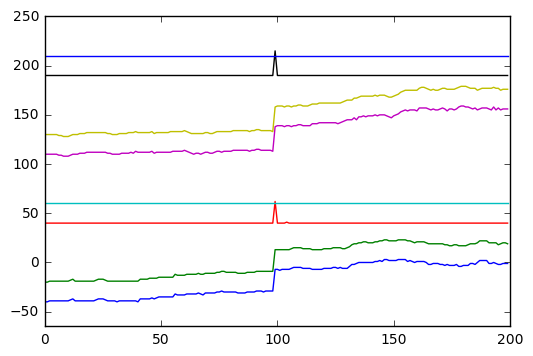

b'germline_del_end' id: 7994


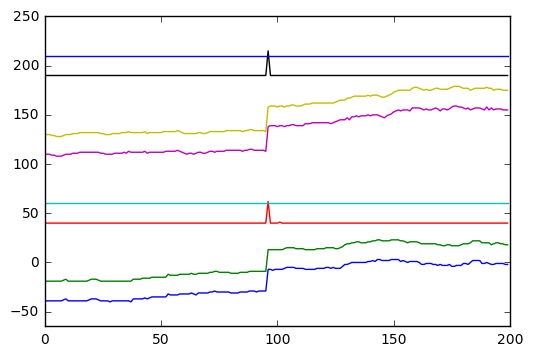

b'germline_del_end' id: 7995


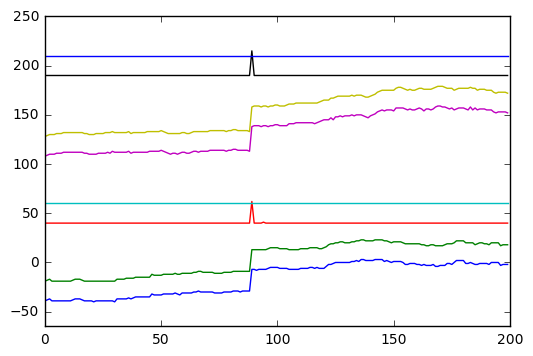

b'germline_del_end' id: 7996


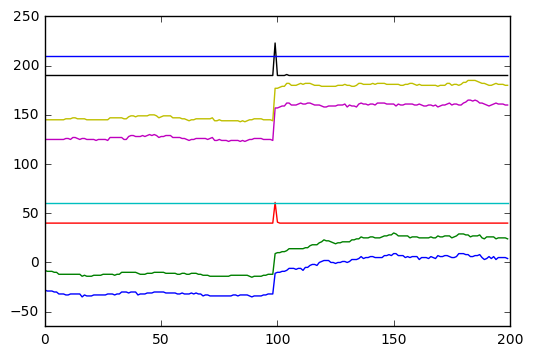

b'germline_del_end' id: 7997


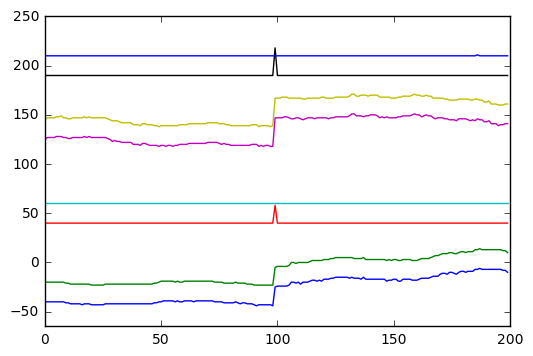

b'germline_del_end' id: 7998


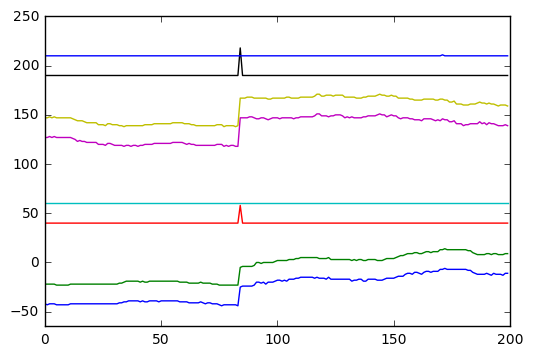

b'germline_del_end' id: 7999


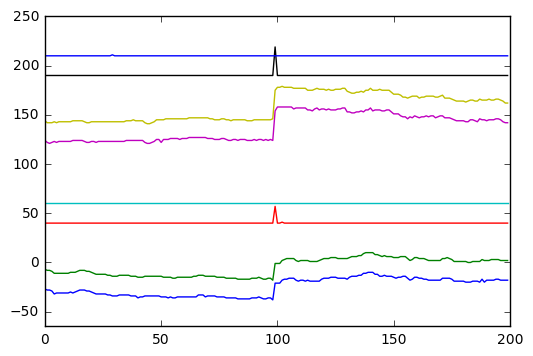

b'germline_ins_start' id: 8000


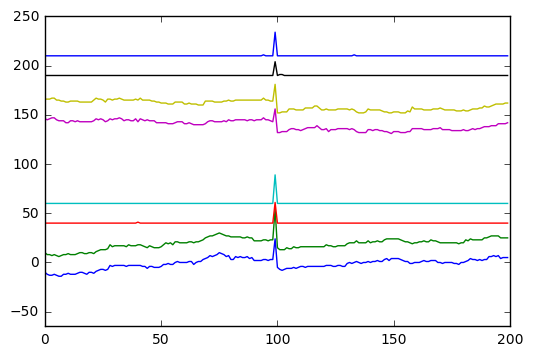

b'germline_ins_start' id: 8001


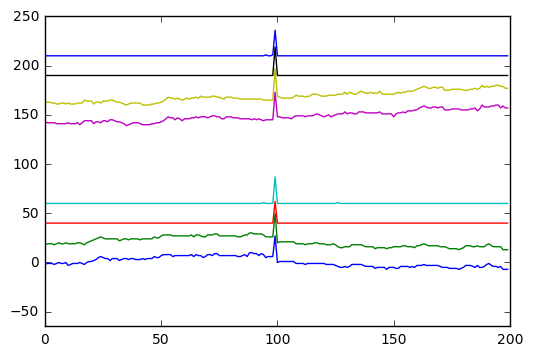

b'germline_ins_start' id: 8002


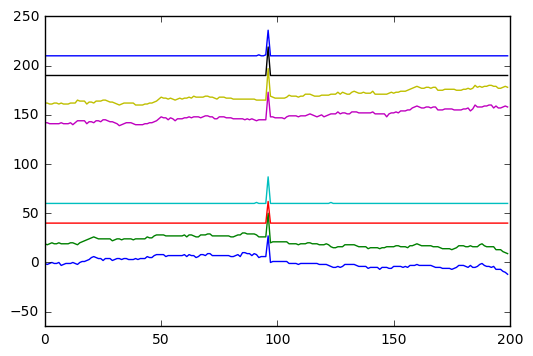

b'germline_ins_start' id: 8003


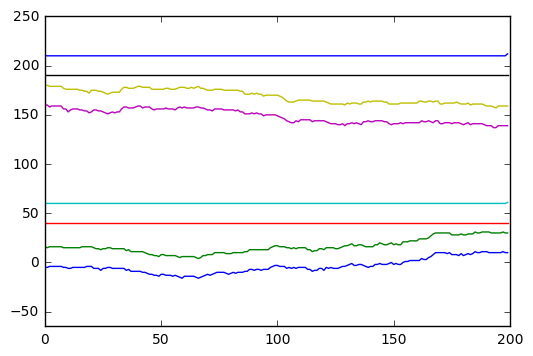

b'germline_ins_start' id: 8004


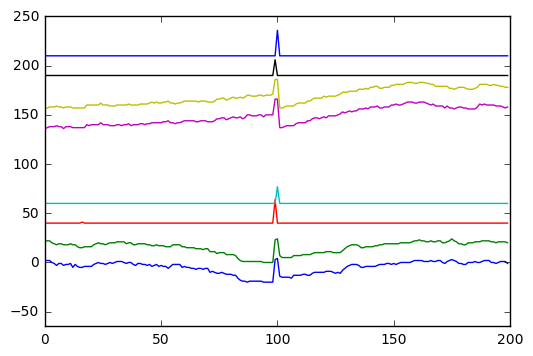

b'germline_ins_start' id: 8005


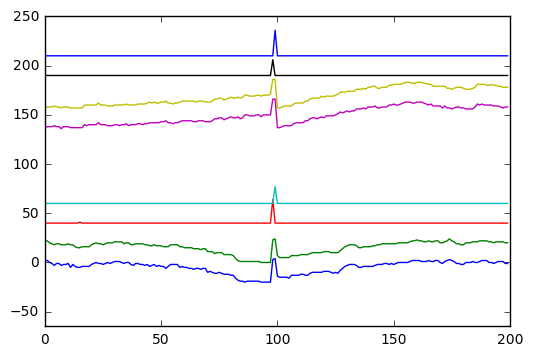

b'germline_ins_start' id: 8006


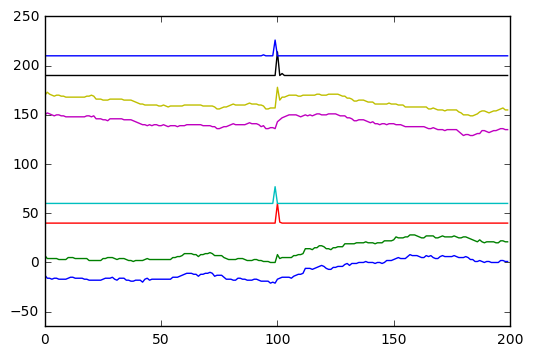

b'germline_ins_start' id: 8007


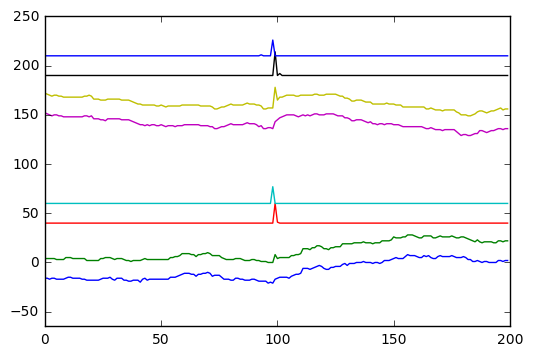

b'germline_ins_start' id: 8008


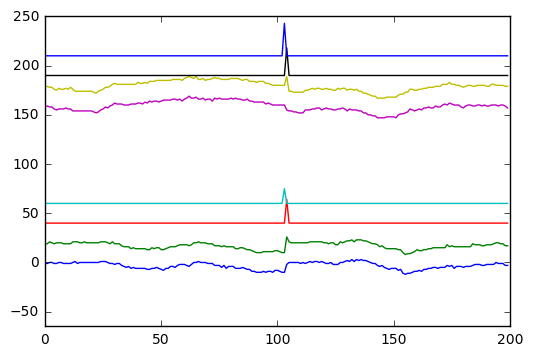

b'germline_ins_start' id: 8009


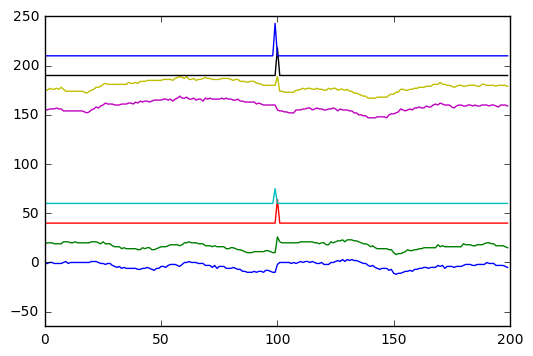

b'germline_ins_start' id: 8010


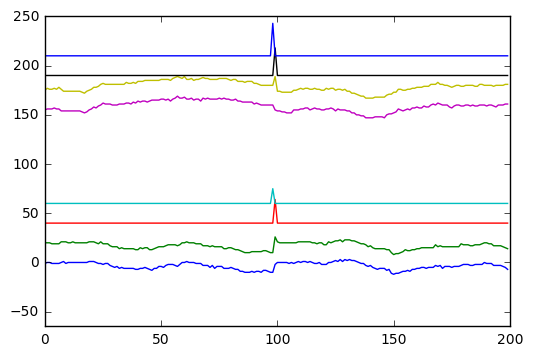

b'germline_ins_start' id: 8011


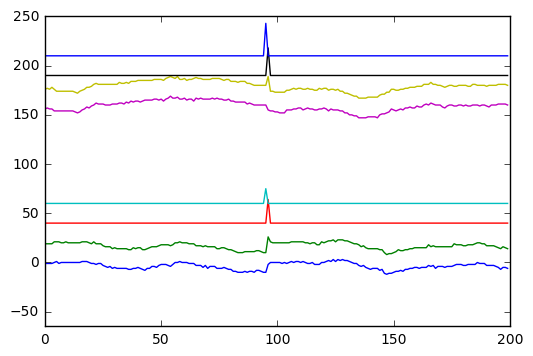

b'germline_ins_start' id: 8012


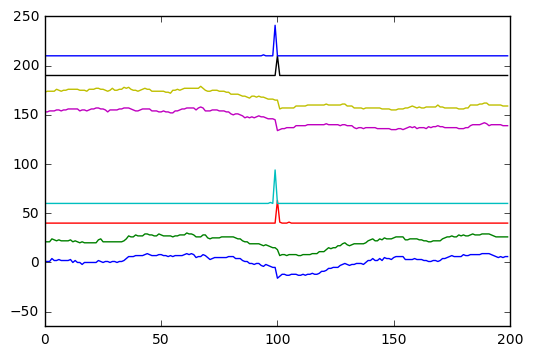

b'germline_ins_start' id: 8013


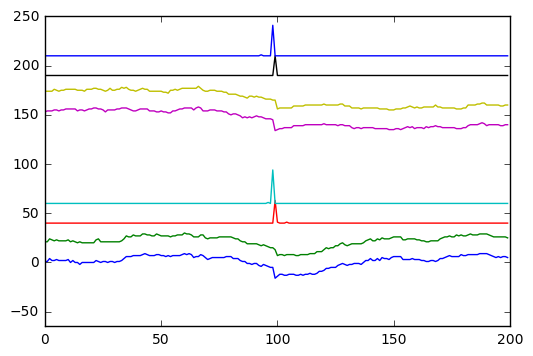

b'germline_ins_start' id: 8014


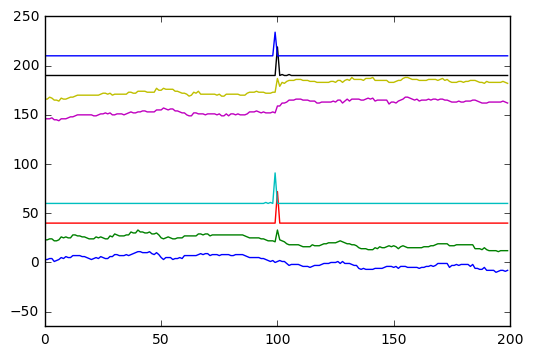

In [125]:
start_window = 7985
plot_channels(start_window, n_windows)

## Plots several windows from the somatic SV category

b'somatic_del_start' id: 19990


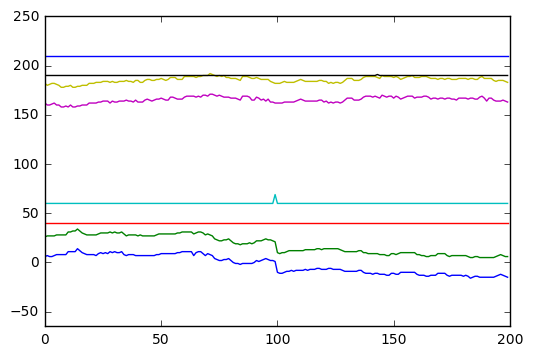

b'somatic_del_start' id: 19991


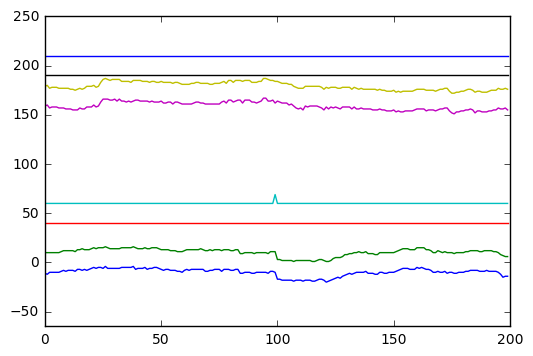

b'somatic_del_start' id: 19992


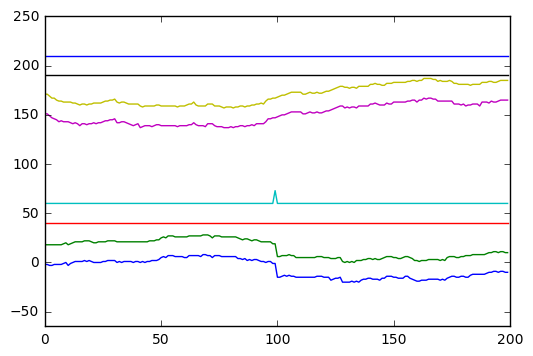

b'somatic_del_start' id: 19993


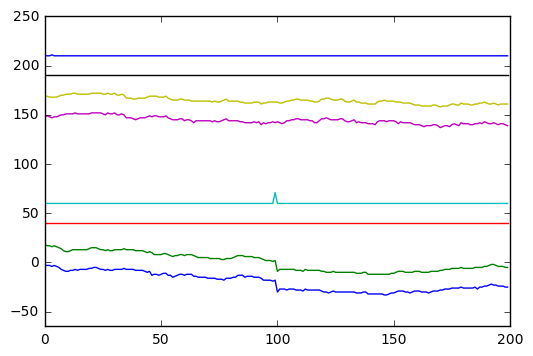

b'somatic_del_start' id: 19994


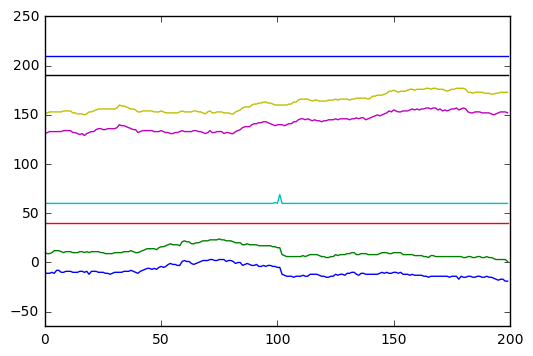

b'somatic_del_start' id: 19995


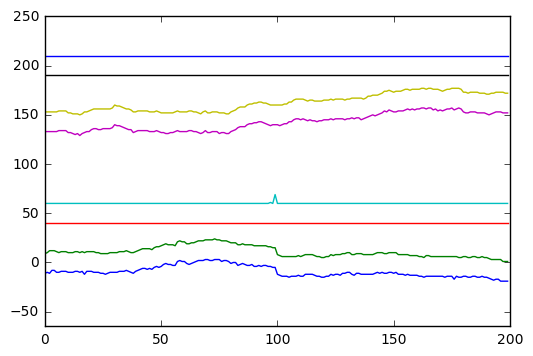

b'somatic_del_start' id: 19996


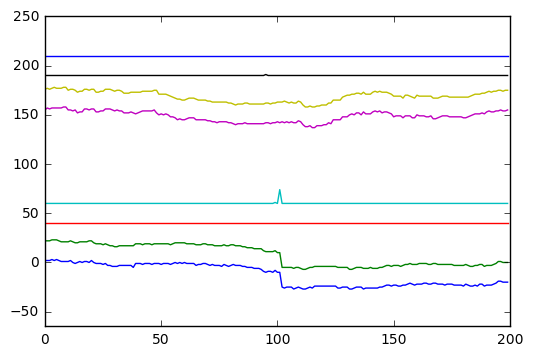

b'somatic_del_start' id: 19997


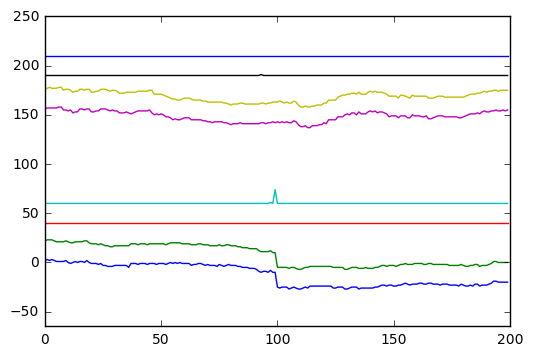

b'somatic_del_start' id: 19998


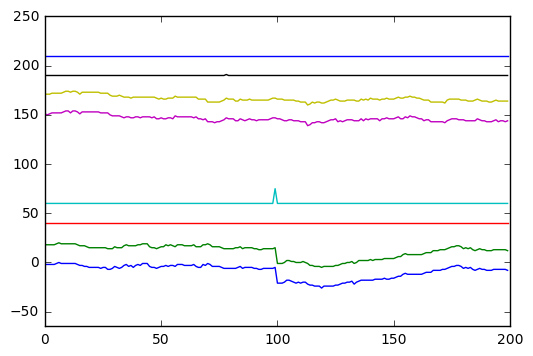

b'somatic_del_start' id: 19999


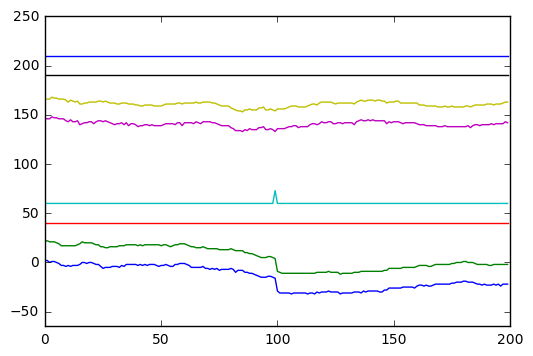

b'somatic_del_end' id: 20000


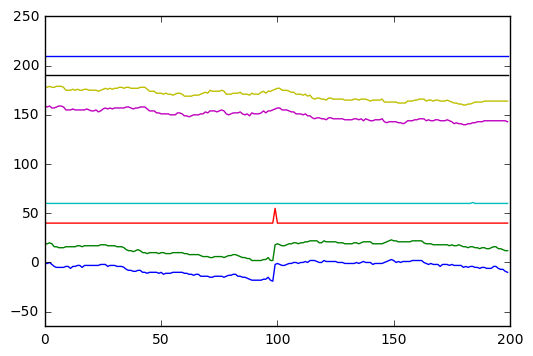

b'somatic_del_end' id: 20001


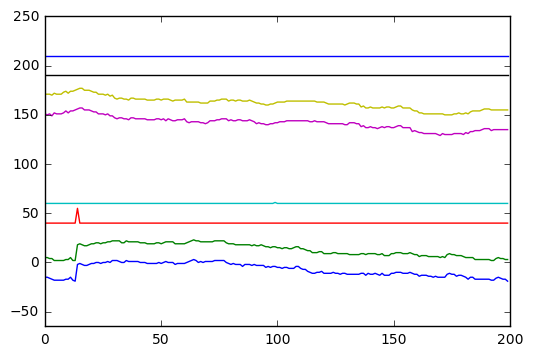

b'somatic_del_end' id: 20002


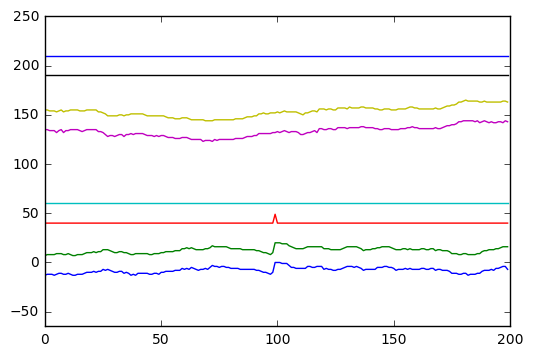

b'somatic_del_end' id: 20003


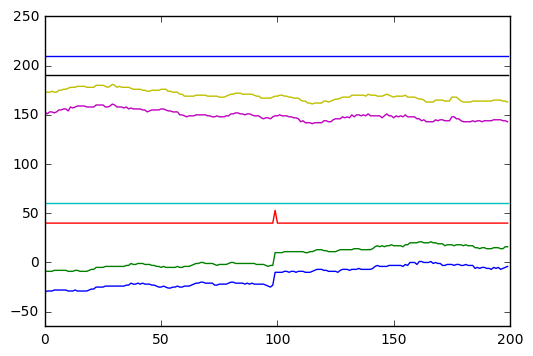

b'somatic_del_end' id: 20004


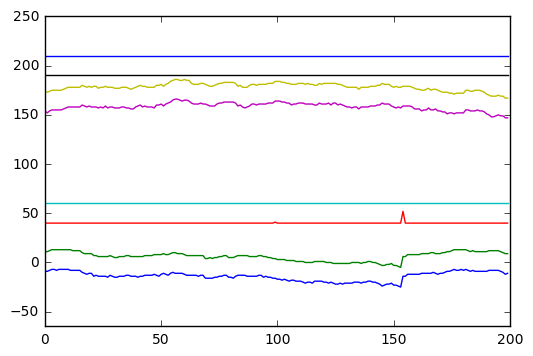

b'somatic_del_end' id: 20005


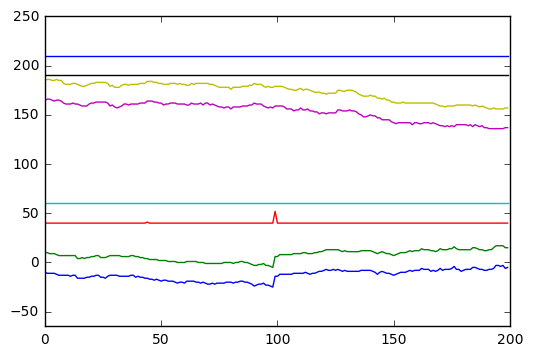

b'somatic_del_end' id: 20006


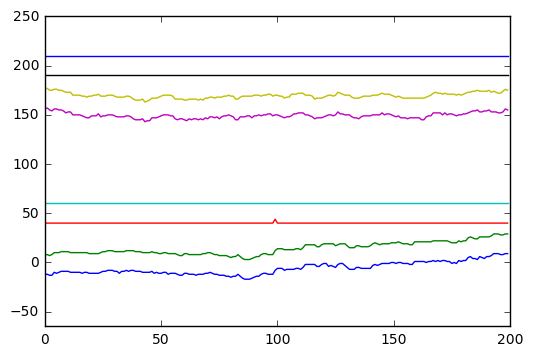

b'somatic_del_end' id: 20007


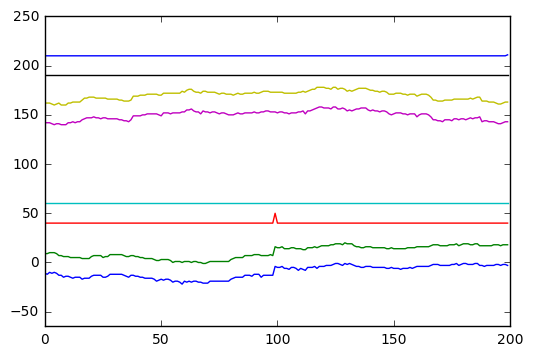

b'somatic_del_end' id: 20008


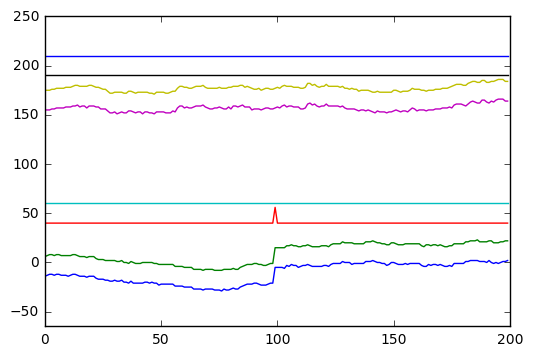

b'somatic_del_end' id: 20009


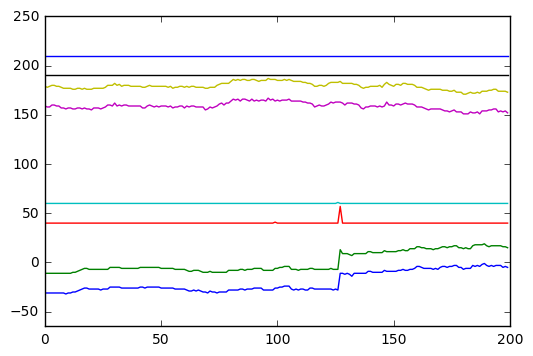

b'somatic_del_end' id: 20010


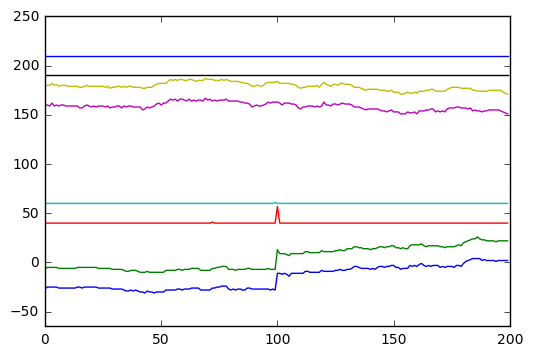

b'somatic_del_end' id: 20011


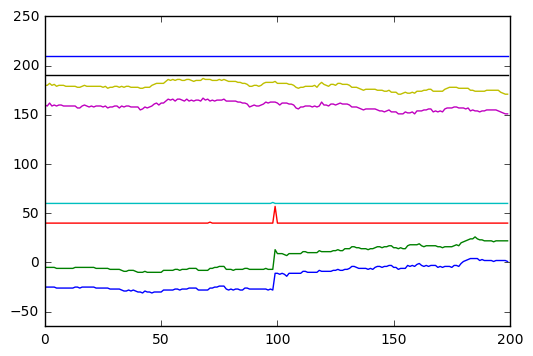

b'somatic_del_end' id: 20012


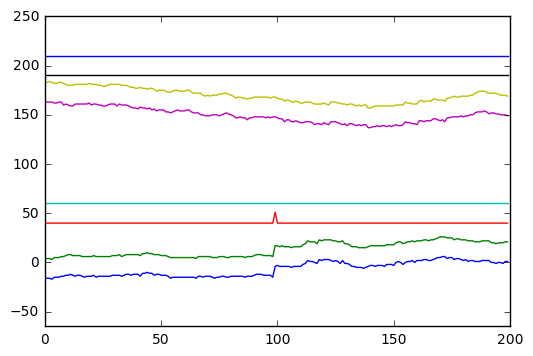

b'somatic_del_end' id: 20013


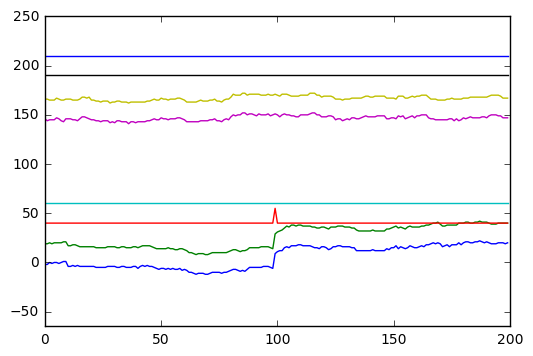

b'somatic_del_end' id: 20014


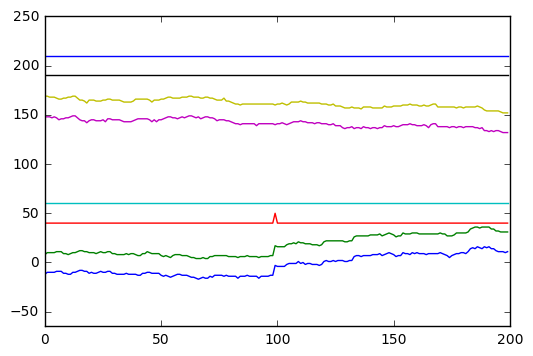

b'somatic_del_end' id: 20015


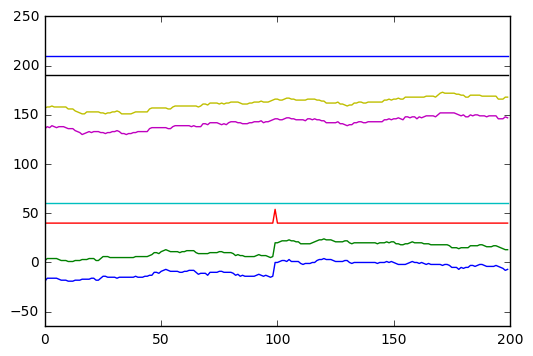

b'somatic_del_end' id: 20016


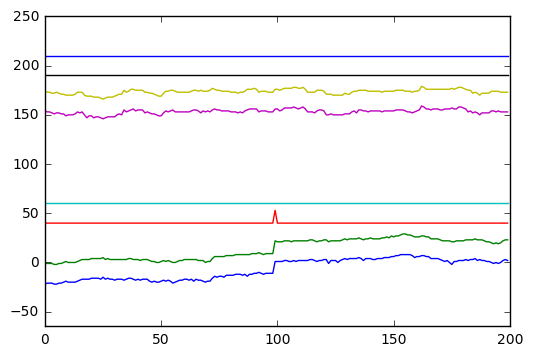

b'somatic_del_end' id: 20017


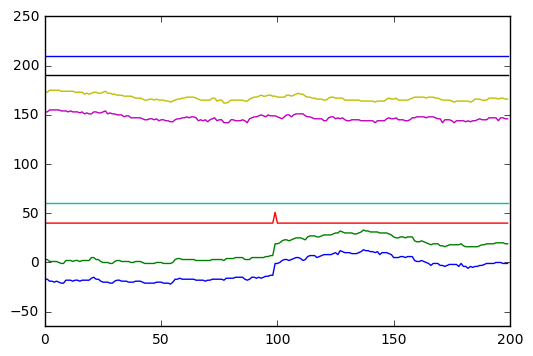

b'somatic_del_end' id: 20018


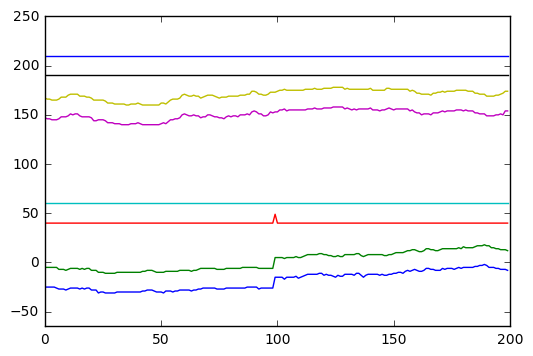

b'somatic_del_end' id: 20019


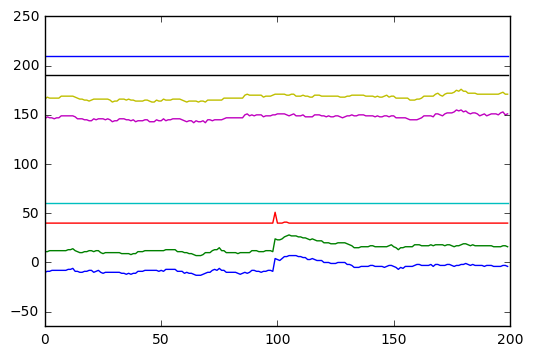

In [123]:

start_window = 3990+16000

plot_channels(start_window, n_windows)

b'somatic_del_end' id: 23990


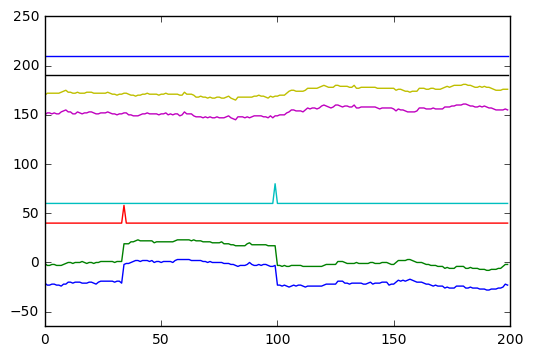

b'somatic_del_end' id: 23991


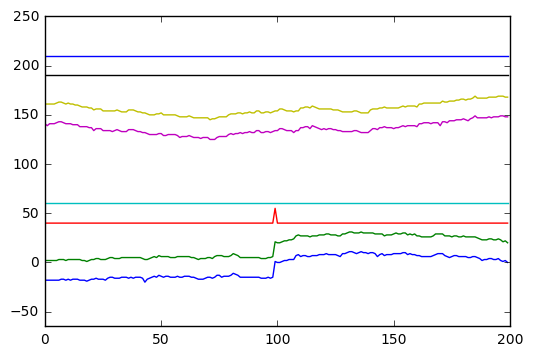

b'somatic_del_end' id: 23992


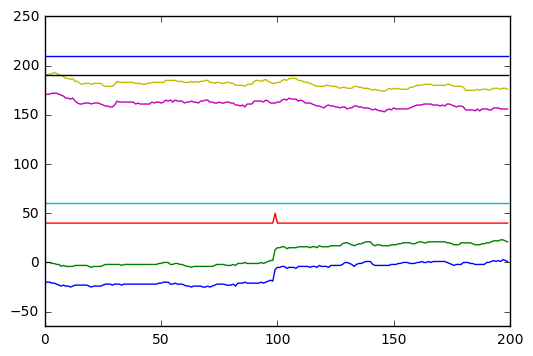

b'somatic_del_end' id: 23993


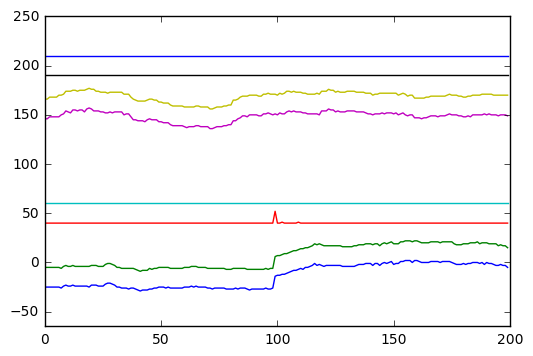

b'somatic_del_end' id: 23994


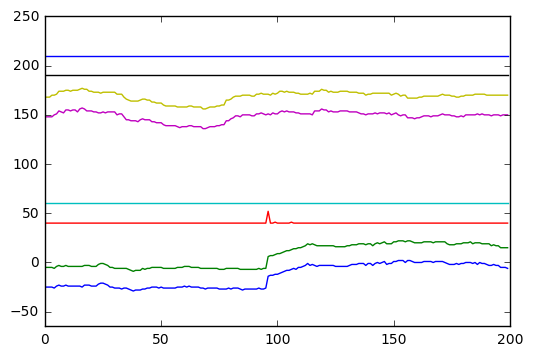

b'somatic_del_end' id: 23995


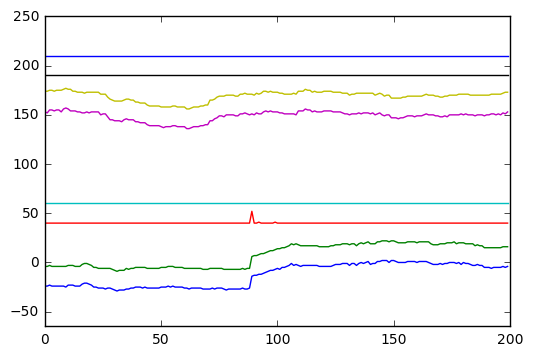

b'somatic_del_end' id: 23996


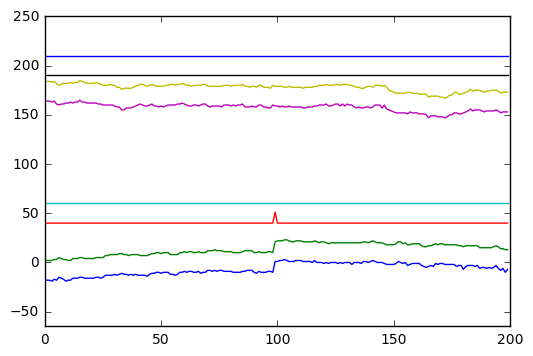

b'somatic_del_end' id: 23997


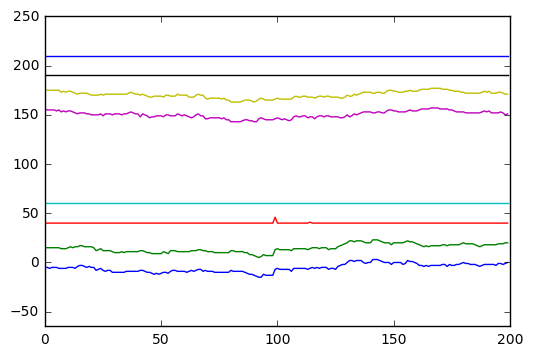

b'somatic_del_end' id: 23998


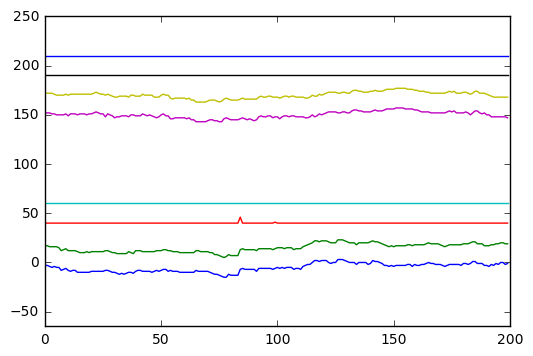

b'somatic_del_end' id: 23999


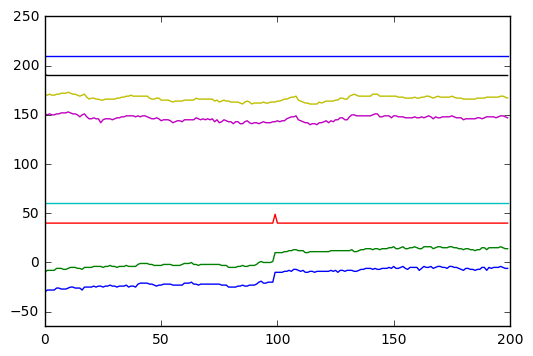

b'somatic_ins_start' id: 24000


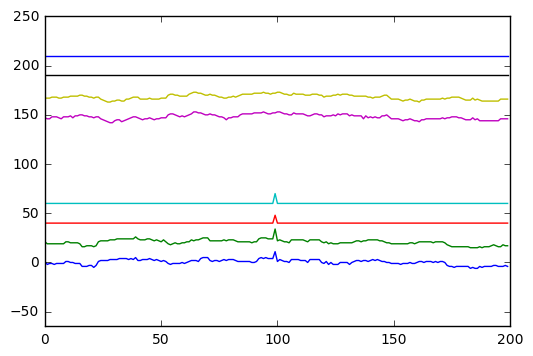

b'somatic_ins_start' id: 24001


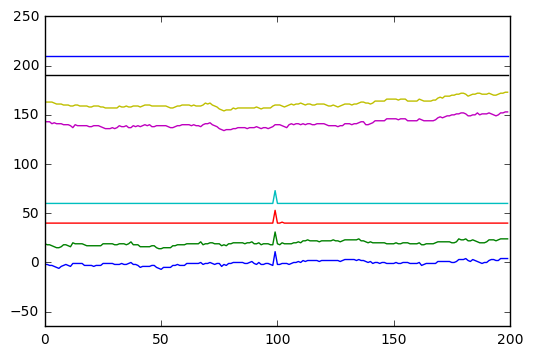

b'somatic_ins_start' id: 24002


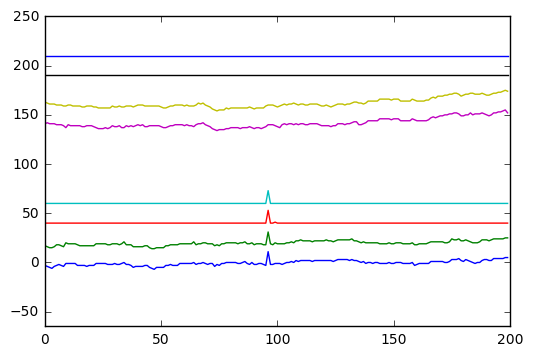

b'somatic_ins_start' id: 24003


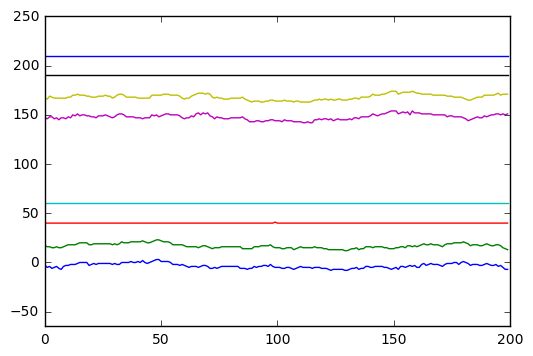

b'somatic_ins_start' id: 24004


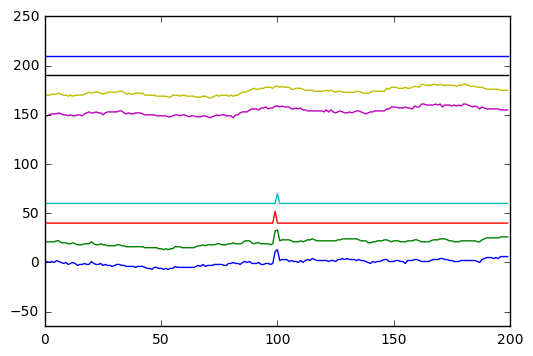

b'somatic_ins_start' id: 24005


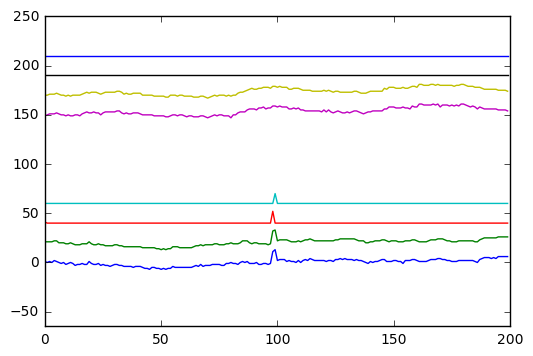

b'somatic_ins_start' id: 24006


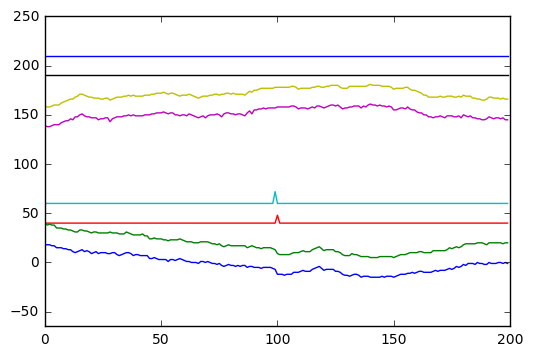

b'somatic_ins_start' id: 24007


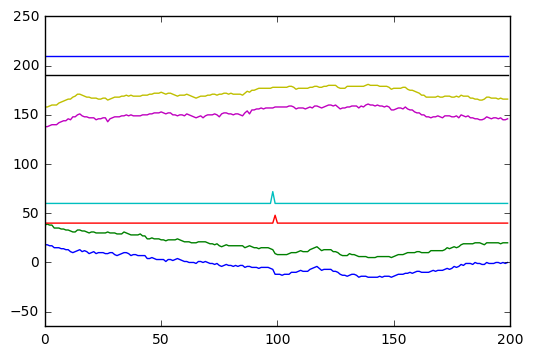

b'somatic_ins_start' id: 24008


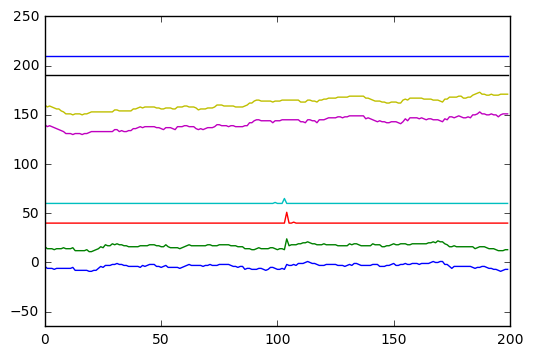

b'somatic_ins_start' id: 24009


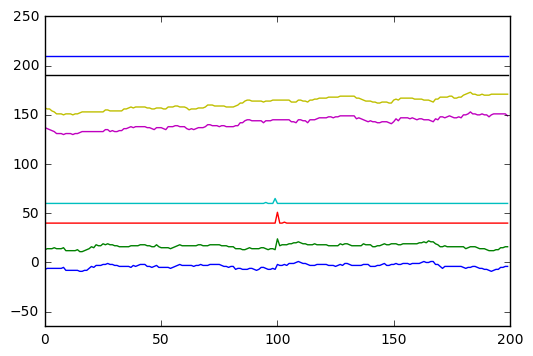

b'somatic_ins_start' id: 24010


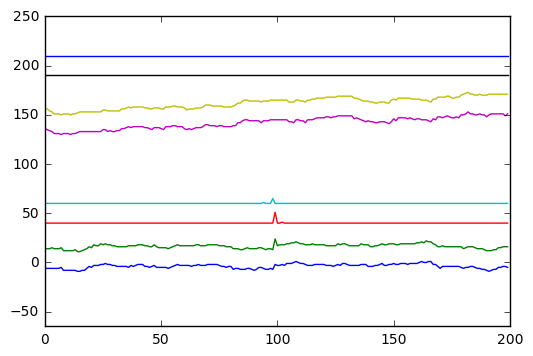

b'somatic_ins_start' id: 24011


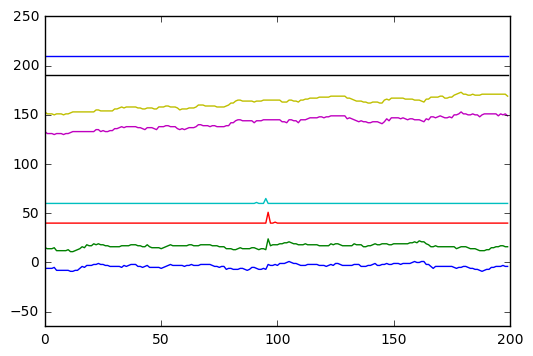

b'somatic_ins_start' id: 24012


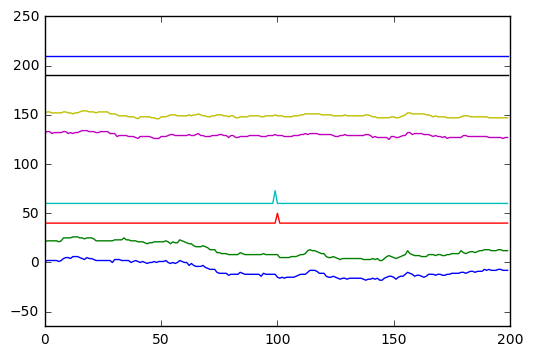

b'somatic_ins_start' id: 24013


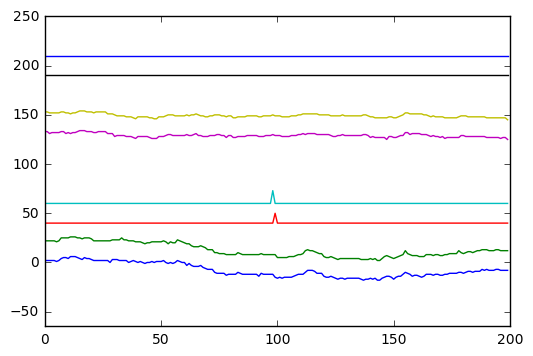

b'somatic_ins_start' id: 24014


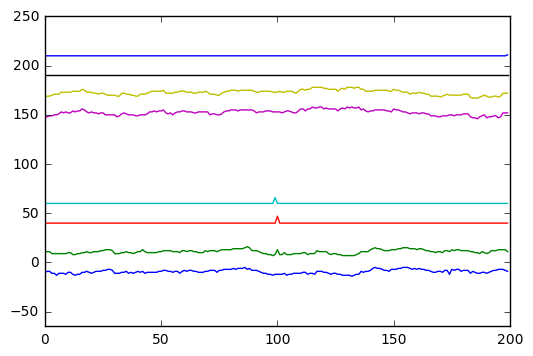

b'somatic_ins_start' id: 24015


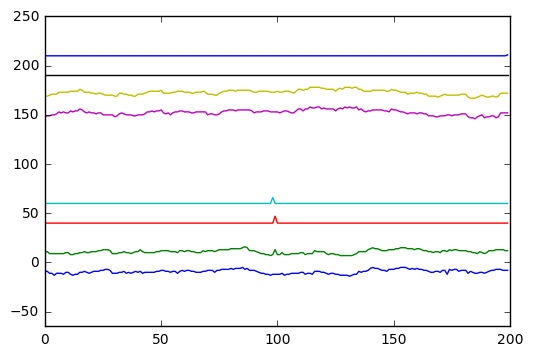

b'somatic_ins_start' id: 24016


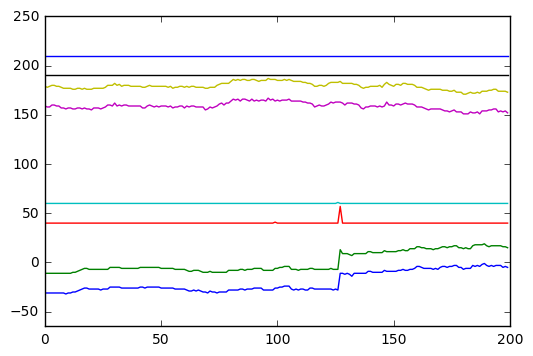

b'somatic_ins_start' id: 24017


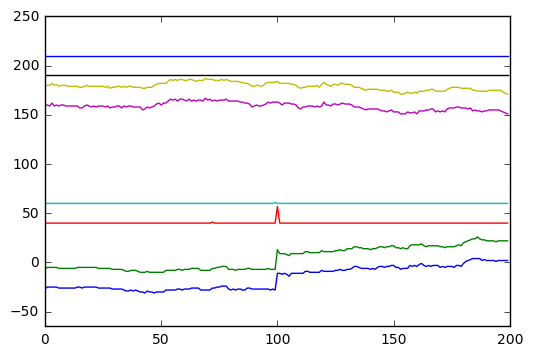

b'somatic_ins_start' id: 24018


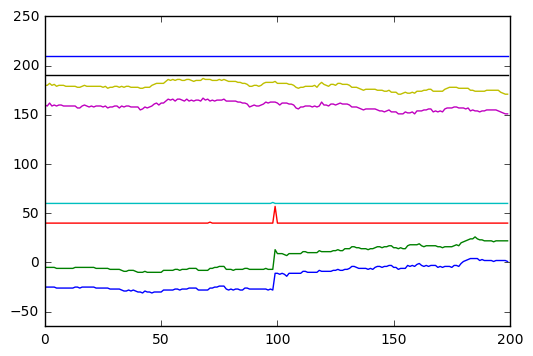

b'somatic_ins_start' id: 24019


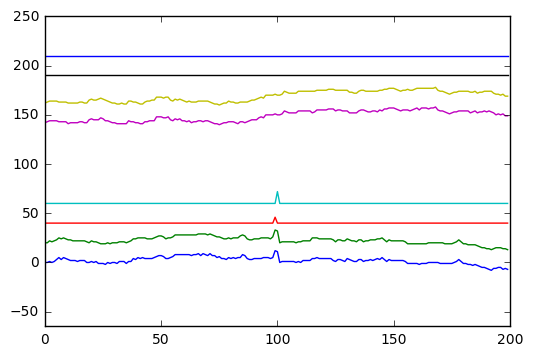

In [124]:
start_window = 7990+16000
plot_channels(start_window, n_windows)

   
## Transposes every window in X, to comply to McFly format

In [131]:
def transposeDataset(X):
    image = []
    for i in range (0, len(X -1)):
        tr = X[i].transpose()
        image.append(tr)
    return np.array(image)

image1 = transposeDataset(X_train)
image2 = transposeDataset(X_val)
image3 = transposeDataset(X_test)
X_train = image1
X_val = image2
X_test = image3

n_channels = len(X_train[0][0])
print(len(X_test[0][0]))

8


## Prepare the labels in McFly format

In [132]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_val], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

{b'germline_del_end': 0, b'somatic_del_end': 1, b'germline_del_start': 2, b'somatic_ins_start': 3, b'germline_ins_start': 5, b'somatic_del_start': 4}


In [133]:
y_test_binary

array([[ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.]])

In [134]:
y_val_binary

array([[ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.]])

In [135]:
X_train.shape

(32000, 200, 8)

## Generate neural networks architectures

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))
from mcfly import modelgen, find_architecture

In [37]:
np.random.seed = 321
num_classes = y_train_binary.shape[1]

In [38]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 1,
                                  model_type = 'CNN',
                                  cnn_min_layers=1,
                                  cnn_max_layers=1,
                                  cnn_min_fc_nodes=5, 
                                  cnn_max_fc_nodes=15,
                                  low_lr=4, high_lr=8)

CPU times: user 596 ms, sys: 84 ms, total: 680 ms
Wall time: 1.94 s


In [39]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'learning_rate': 1.5526198952299947e-05, 'fc_hidden_nodes': 13, 'regularization_rate': 0.03493811197088269, 'filters': array([94])}
____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
batchnormalization_1 (BatchNormaliz(None, 200, 8)      16          batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)    (None, 200, 94)     2350        batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNormaliz(None, 200, 94)     188         convolution1d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 200, 94)     0   

## Train the networks

In [40]:
train_set_size = X_train.shape[0]
train_set_size

32000

In [67]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=3, 
                                                                                  subset_size=train_set_size,
                                                                                  verbose=True)

Training model 0 CNN
Train on 32000 samples, validate on 8000 samples
Epoch 1/3
32000/32000 [==============================] - 119s - loss: 0.8469 - acc: 0.9415 - val_loss: 0.2893 - val_acc: 0.9475
Epoch 2/3
32000/32000 [==============================] - 106s - loss: 0.8062 - acc: 0.9410 - val_loss: 0.2814 - val_acc: 0.9497
Epoch 3/3
32000/32000 [==============================] - 106s - loss: 0.7680 - acc: 0.9421 - val_loss: 0.2747 - val_acc: 0.9492
CPU times: user 8min 5s, sys: 34.8 s, total: 8min 39s
Wall time: 5min 33s


## Plot training process

Currently run with a very low number of epochs

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 165 ms


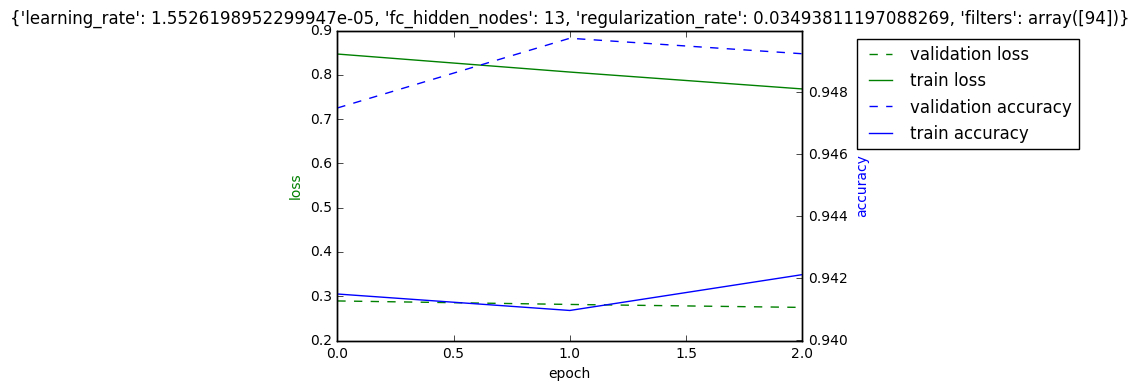

In [68]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [69]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'learning_rate': 1.5526198952299947e-05, 'fc_...",0.942125,0.768037,0.94925,0.274715


## Take the best current model 

In [70]:
best_model_index = np.argmax(val_accuracies)

In [71]:
best_model_index

0

In [72]:
import theano
theano.config.mode

'Mode'

In [73]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

0 CNN {'learning_rate': 1.5526198952299947e-05, 'fc_hidden_nodes': 13, 'regularization_rate': 0.03493811197088269, 'filters': array([94])}


In [74]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'])
best_model_copy = best_model
print(best_model_index, best_model_types, best_params)

0 CNN {'learning_rate': 1.5526198952299947e-05, 'fc_hidden_nodes': 13, 'regularization_rate': 0.03493811197088269, 'filters': array([94])}


## Save the best current model

In [75]:
from mcfly import storage
name_best_model = 'Gtcg_3_19_2_18_val2'

In [76]:
storage.savemodel(best_model,'/home/sonja/sonja/',name_best_model )

('/home/sonja/sonja/Gtcg_3_19_2_18_val2_architecture.json',
 '/home/sonja/sonja/Gtcg_3_19_2_18_val2_weights')

## Reload the best current model

In [147]:

from mcfly import storage
model_reloaded = storage.loadmodel('/home/sonja/sonja/',name_best_model )
model_reloaded.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(best_params['learning_rate']), 
                  metrics=['accuracy']) 

## Train the best model 

In [ ]:
nr_epochs = 10

datasize = X_train.shape[0]#1000
history = model_reloaded.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary))

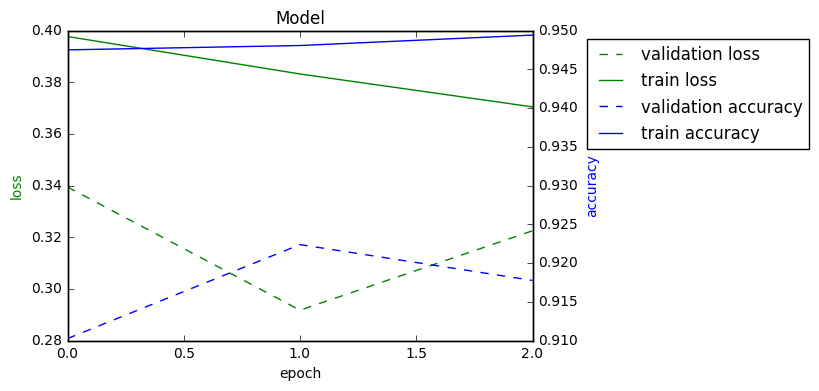

In [116]:
find_architecture.plotTrainingProcess(history)

## Test best current model on testset

### Overall accuracy on the test set:

In [148]:
score_test = model_reloaded.evaluate(X_test, y_test_binary, verbose=False)
print('Test loss and accuracy of best model: ' + str(score_test))

Test loss and accuracy of best model: [0.28374075816657407, 0.94371613353266826]


### Re-check the train and validation scores: 

In [79]:
best_model.get_config()[0]

{'class_name': 'BatchNormalization',
 'config': {'axis': 2,
  'batch_input_shape': (None, 200, 8),
  'epsilon': 1e-06,
  'input_dtype': 'float32',
  'mode': 0,
  'momentum': 0.9,
  'name': 'batchnormalization_1',
  'trainable': True}}

In [80]:
score_train = model_reloaded.evaluate(X_train, y_train_binary, verbose=False)
print('Train Score of best model: ' + str(score_train))

Train Score of best model: [0.25073743193596604, 0.96174999999999999]


In [81]:
score_val = model_reloaded.evaluate(X_val, y_val_binary, verbose=False)
print('Val Score of best model: ' + str(score_val))

Val Score of best model: [0.27471505850553513, 0.94925000000000004]
